In [1]:
import os
import pandas as pd

In [3]:
# Get the directory with the notebooks, including its subdirectories
current_dir = os.getcwd()

# Get the directories with data and results
data_dir = os.path.join(current_dir, "data/debloating")
temporary_dir= os.path.join(current_dir, "debloating_temporary_data")
results_dir = os.path.join(current_dir, "debloating_results")

project_dir = os.path.dirname(current_dir)

print(project_dir, current_dir, results_dir, data_dir)

/home/qperez/PycharmProjects/bloat-energy-consumption /home/qperez/PycharmProjects/bloat-energy-consumption/notebooks /home/qperez/PycharmProjects/bloat-energy-consumption/notebooks/debloating_results /home/qperez/PycharmProjects/bloat-energy-consumption/notebooks/data/debloating


In [23]:
# Using this function, the purpose is to cancatenate all generated measurements for each repeated experiment 
def concatenate_csv_files(directory_path, output_file):
    file_list = os.listdir(directory_path)
    csv_files = [file for file in file_list if file.endswith(".csv")]

    if not csv_files:
        print("No CSV files found in the directory.")
        return

    dfs = []
    for file in csv_files:
        file_path = os.path.join(directory_path, file)
        df = pd.read_csv(file_path, delimiter=';') # This is important, the delimiter
        
        filename_parts = file[:-4].split("_")  # Split filename and remove ".csv" extension        
        df['Program'] = filename_parts[0].split("-")[0]
        df['TestNr'] = filename_parts[0].split("-")[1]
        df['Utilities'] = filename_parts[1]
        dfs.append(df)

    concatenated_df = pd.concat(dfs, ignore_index=True)
    concatenated_df.to_csv(output_file, index=False, sep=';')  # Use semicolon as delimiter

    print(f"CSV files concatenated and saved to '{output_file}'.")

for i in range(1,11):
    # All data into files in the folder save in a new CSV file
    input_data = os.path.join(data_dir, 'repeat'+str(i)+'/') # You need to change this for each new folder that you want to concatenate its files
    output_data = os.path.join(results_dir, 'cat_repeat'+str(i)+'.csv') # You need to change this for each new folder given above

    concatenate_csv_files(input_data, output_data)

CSV files concatenated and saved to '/home/sandbox/Energy/bloat-energy-consumption/notebooks/debloating_results/cat_repeat1.csv'.
CSV files concatenated and saved to '/home/sandbox/Energy/bloat-energy-consumption/notebooks/debloating_results/cat_repeat2.csv'.
CSV files concatenated and saved to '/home/sandbox/Energy/bloat-energy-consumption/notebooks/debloating_results/cat_repeat3.csv'.
CSV files concatenated and saved to '/home/sandbox/Energy/bloat-energy-consumption/notebooks/debloating_results/cat_repeat4.csv'.
CSV files concatenated and saved to '/home/sandbox/Energy/bloat-energy-consumption/notebooks/debloating_results/cat_repeat5.csv'.
CSV files concatenated and saved to '/home/sandbox/Energy/bloat-energy-consumption/notebooks/debloating_results/cat_repeat6.csv'.
CSV files concatenated and saved to '/home/sandbox/Energy/bloat-energy-consumption/notebooks/debloating_results/cat_repeat7.csv'.
CSV files concatenated and saved to '/home/sandbox/Energy/bloat-energy-consumption/noteboo

In [24]:
# Using this function, the purpose is to concatenate all resulting files from all 5 executions
def concatenate_allcsv_files(directory_path, output_file):
    file_list = os.listdir(directory_path)
    csv_files = [file for file in file_list if file.endswith(".csv")]

    if not csv_files:
        print("No CSV files found in the directory.")
        return

    dfs = []
    for file in csv_files:
        file_path = os.path.join(directory_path, file)
        df = pd.read_csv(file_path, delimiter=';') # This is important, the delimiter
        df['Repetition'] = file  # Add filename as a new column
        dfs.append(df)

    concatenated_df = pd.concat(dfs, ignore_index=True)
    concatenated_df.to_csv(output_file, index=False, sep=';')  # Use semicolon as delimiter


    print(f"CSV files concatenated and saved to '{output_file}'.")

# Save in a new CSV file
output_alldata = os.path.join(results_dir, 'cat_all_repeats.csv')

concatenate_allcsv_files(temporary_dir, output_alldata)

CSV files concatenated and saved to '/home/sandbox/Energy/bloat-energy-consumption/notebooks/debloating_results/cat_all_repeats.csv'.


In [25]:
# Now we need to find the average value of PSYS for all measurements of a program 
def calculate_average_PSYS(input_file, output_file):
    # Read the CSV file
    df = pd.read_csv(input_file, delimiter=';')
    
    # Calculate average of 'PSYS' column for each unique combination of 'Program' and 'Utilities'
    average_psys = df.groupby(['Program', 'Utilities'])['PSYS'].mean().reset_index()
    
    # Write the average values to a new file separated with a semicolon
    average_psys.to_csv(output_file, index=False, sep=';')
    
    print(f"Average PSYS values written to '{output_file}'.")

# Required inputs and outputs
input_data = os.path.join(results_dir, 'cat_all_repeats.csv')
output_data = os.path.join(results_dir, 'averagePSYS_all_repeats.csv')

calculate_average_PSYS(input_data, output_data)


Average PSYS values written to '/home/sandbox/Energy/bloat-energy-consumption/notebooks/debloating_results/averagePSYS_all_repeats.csv'.


In [26]:

def calculate_average_and_std_PSYS(input_file, output_file):
    # Read the CSV file
    df = pd.read_csv(input_file, delimiter=';')
    
    # Convert 'PSYS' values from microjoules to joules
    # df['PSYS'] = df['PSYS'] / 1000000  # 1 microjoule = 1e-6 joules

    # Calculate average of 'PSYS' column for each unique combination of 'Program' and 'Utilities'
    average_psys = df.groupby(['Program', 'Utilities'])['PSYS'].mean().reset_index()
    average_psys['PSYS'] = average_psys['PSYS'].round(2)  # Round the average values to 2 decimals

    # Calculate standard deviation of 'PSYS' column for each unique combination of 'Program' and 'Utilities'
    std_psys = df.groupby(['Program', 'Utilities'])['PSYS'].std().reset_index()
    std_psys['PSYS'] = std_psys['PSYS'].round(2)  # Round the standard deviation values to 2 decimals
    
    # Merge the average and standard deviation DataFrames based on 'Program' and 'Utilities' columns
    result_df = pd.merge(average_psys, std_psys, on=['Program', 'Utilities'], suffixes=('_avg', '_std'))

    # Write the average and standard deviation values to a new file separated with a semicolon
    result_df.to_csv(output_file, index=False, sep=';')

    print(f"Average PSYS and STD values written to '{output_file}'.")

# Required inputs and outputs
input_data = os.path.join(results_dir, 'cat_all_repeats.csv')
output_data = os.path.join(results_dir, 'averagePSYS_with_std_all_repeats.csv')

calculate_average_and_std_PSYS(input_data, output_data)

Average PSYS and STD values written to '/home/sandbox/Energy/bloat-energy-consumption/notebooks/debloating_results/averagePSYS_with_std_all_repeats.csv'.


In [3]:
import pandas as pd

# Required inputs and outputs
input_data = os.path.join(results_dir, 'averagePSYS_with_std_all_repeats.csv')
output_data = os.path.join(results_dir, 'averagePSYS_with_std_all_repeats_pivot.csv')

data = pd.read_csv(input_data, sep=';')

# Pivot the data to create new columns for GNU, ToyBox, and BusyBox
pivoted_data = data.pivot(index='Program', columns='Utilities', values=['PSYS_avg', 'PSYS_std'])

# Flatten the multi-level column index
pivoted_data.columns = [f'{col[0]}_{col[1]}' for col in pivoted_data.columns]

# Reset the index to make 'Program' a regular column again
pivoted_data = pivoted_data.reset_index()

pivoted_data.to_csv(output_data, index=False, sep=';')

# Display the reorganized data
print(pivoted_data)


       Program  PSYS_avg_bloated  PSYS_avg_chisel  PSYS_avg_cov  \
0         date         287914.25        284160.70     284352.85   
1         grep         317086.10        457307.85     315260.85   
2         gzip         334755.55        549107.40     331841.20   
3        mkdir         289446.30        287996.70     287615.30   
4  printokens2         282000.05        281304.40     285134.15   
5          sed         285567.55        288768.75     290404.50   

   PSYS_avg_debop  PSYS_std_bloated  PSYS_std_chisel  PSYS_std_cov  \
0       284331.55          14287.28          9876.11       9444.81   
1       315404.45          19601.77         20620.21      17533.55   
2       331715.95          12876.30         22471.20      16107.98   
3       287520.60          15787.29         13904.30      11606.01   
4       281771.20           8763.53         12498.42      21416.34   
5       287371.10           9693.99         15200.94      21546.36   

   PSYS_std_debop  
0         9677.53  

In [4]:
# Now we need to find the average value of PSYS and DURATION for all measurements of a program 
def calculate_average_PSYS_DURATION(input_file, output_file):
    # Read the CSV file
    df = pd.read_csv(input_file, delimiter=';')
    
    # Calculate average of 'PSYS' column for each unique combination of 'Program' and 'Utilities'
    average_psys = df.groupby(['Program', 'Utilities'])['PSYS'].mean().reset_index()
    
    # Calculate average of 'DURATION' column for each unique combination of 'Program' and 'Utilities'
    average_duration = df.groupby(['Program', 'Utilities'])['DURATION'].mean().reset_index()
    
    # Merge the two DataFrames based on 'Program' and 'Utilities'
    merged_df = pd.merge(average_psys, average_duration, on=['Program', 'Utilities'])
    
    # Write the average values to a new file separated with a semicolon
    merged_df.to_csv(output_file, index=False, sep=';')
    
    print(f"Average PSYS and DURATION values written to '{output_file}'.")

# Required inputs and outputs
input_data = os.path.join(results_dir, 'cat_all_repeats.csv')
output_data = os.path.join(results_dir, 'averageDURATION_all_repeats.csv')

calculate_average_PSYS_DURATION(input_data, output_data)

Average PSYS and DURATION values written to '/home/qperez/PycharmProjects/bloat-energy-consumption/notebooks/debloating_results/averageDURATION_all_repeats.csv'.


In [9]:
# After we need to put together the PSYS and Size values for each program in each of the 3 different implementations

csv_with_ec = os.path.join(results_dir, 'averagePSYS_all_repeats.csv')
csv_with_size = os.path.join(results_dir, 'debloat_experiments_size.csv') 
output_file = os.path.join(results_dir, 'all_ec_bsize.csv')

# Read the first CSV file
df1 = pd.read_csv(csv_with_ec, delimiter=';')

# Read the second CSV file
df2 = pd.read_csv(csv_with_size, delimiter=';')
print(df2)

# Merge the two DataFrames based on 'Program' column
merged_df = pd.merge(df1, df2, on='Program')
# Add the 'Size' values for each 'Utilities' based on the Program and fillna with 0 if not found
df1['Size'] = merged_df.apply(lambda row: row[row['Utilities']], axis=1)
print(df1)

# Save the final DataFrame to a new CSV file, including 'Utilities' and 'PSYS' columns
df1.to_csv(output_file, index=False, sep=';')


   Nr      Program  bloated  chisel  debop    cov
0   0         date    94240   27952  37536  37536
1   1         grep   162640  111664  87664  87656
2   2         gzip   104152   91720  56624  56616
3   3        mkdir    49360   19696  23392  23392
4   4  printokens2    21176   21168  21192  21184
5   5          sed   174472  155224  85772  87856
        Program Utilities       PSYS    Size
0          date   bloated  287914.25   94240
1          date    chisel  284160.70   27952
2          date       cov  284352.85   37536
3          date     debop  284331.55   37536
4          grep   bloated  317086.10  162640
5          grep    chisel  457307.85  111664
6          grep       cov  315260.85   87656
7          grep     debop  315404.45   87664
8          gzip   bloated  334755.55  104152
9          gzip    chisel  549107.40   91720
10         gzip       cov  331841.20   56616
11         gzip     debop  331715.95   56624
12        mkdir   bloated  289446.30   49360
13        mkdir    c

In [20]:
# After we need to put together the PSYS and number of Configuration Options for each program in each of the 3 different implementations

csv_with_ec = os.path.join(results_dir, 'averagePSYS_all_repeats.csv')
csv_with_size = os.path.join(project_dir, 'inputs/programs_nr_options.csv') 
output_file = os.path.join(results_dir, 'all_ec_options.csv')

# Read the first CSV file
df1 = pd.read_csv(csv_with_ec, delimiter=';')

# Read the second CSV file
df2 = pd.read_csv(csv_with_size, delimiter=';')

# Merge the two DataFrames based on 'Program' column
merged_df = pd.merge(df1, df2, on='Program')

# Add the 'Size' values for each 'Utilities' based on the Program and fillna with 0 if not found
df1['Options'] = merged_df.apply(lambda row: row[row['Utilities']], axis=1)

# Save the final DataFrame to a new CSV file, including 'Utilities' and 'PSYS' columns
df1.to_csv(output_file, index=False, sep=';')


KeyError: 'bloated'

In [14]:
# Now we want to calculate the Peason correlation between the EC and Size 
# for all utilities in each 3 different implementations

# The Spearman correlation with the p-value

import pandas as pd
from scipy.stats import spearmanr

input_data = os.path.join(results_dir, 'all_ec_bsize.csv')
# Read the CSV file into a DataFrame
df = pd.read_csv(input_data, delimiter=";")

# Convert 'PSYS' and 'Size' columns to numeric
df['PSYS'] = pd.to_numeric(df['PSYS'])
df['Size'] = pd.to_numeric(df['Size'])

# Calculate Spearman correlation and p-value for each 'Utilities' separately
results = df.groupby('Utilities').apply(lambda x: spearmanr(x['PSYS'], x['Size']))

# Extract the correlation coefficients and p-values
correlations = results.apply(lambda x: x.correlation)
p_values = results.apply(lambda x: x.pvalue)

# Combine correlations and p-values into a DataFrame
correlation_df = pd.DataFrame({'Spearman Correlation': correlations, 'p-value': p_values})

# Print the correlations and p-values
print(correlation_df)

           Spearman Correlation   p-value
Utilities                                
bloated                0.314286  0.544093
chisel                 0.600000  0.208000
cov                    0.600000  0.208000
debop                  0.600000  0.208000


In [15]:
# The Pearson correlation with the p-value

import pandas as pd
from scipy.stats import pearsonr

input_data = os.path.join(results_dir, 'all_ec_bsize.csv')
# Read the CSV file into a DataFrame
df = pd.read_csv(input_data, delimiter=";")

# Convert 'PSYS' and 'Size' columns to numeric
df['PSYS'] = pd.to_numeric(df['PSYS'])
df['Size'] = pd.to_numeric(df['Size'])

# Calculate Spearman correlation and p-value for each 'Utilities' separately
results = df.groupby('Utilities').apply(lambda x: pearsonr(x['PSYS'], x['Size']))

# Extract the correlation coefficients and p-values
correlations = results.apply(lambda x: x.correlation)
p_values = results.apply(lambda x: x.pvalue)

# Combine correlations and p-values into a DataFrame
correlation_df = pd.DataFrame({'Pearson Correlation': correlations, 'p-value': p_values})

# Print the correlations and p-values
print(correlation_df)

           Pearson Correlation   p-value
Utilities                               
bloated               0.334806  0.516557
chisel                0.386750  0.448800
cov                   0.465291  0.352430
debop                 0.463585  0.354437


        Program Utilities       PSYS    Size
0          date   bloated  287914.25   94240
1          date    chisel  284160.70   27952
2          date       cov  284352.85   37536
3          date     debop  284331.55   37536
4          grep   bloated  317086.10  162640
5          grep    chisel  457307.85  111664
6          grep       cov  315260.85   87656
7          grep     debop  315404.45   87664
8          gzip   bloated  334755.55  104152
9          gzip    chisel  549107.40   91720
10         gzip       cov  331841.20   56616
11         gzip     debop  331715.95   56624
12        mkdir   bloated  289446.30   49360
13        mkdir    chisel  287996.70   19696
14        mkdir       cov  287615.30   23392
15        mkdir     debop  287520.60   23392
16  printokens2   bloated  282000.05   21176
17  printokens2    chisel  281304.40   21168
18  printokens2       cov  285134.15   21184
19  printokens2     debop  281771.20   21192
20          sed   bloated  285567.55  174472
21        

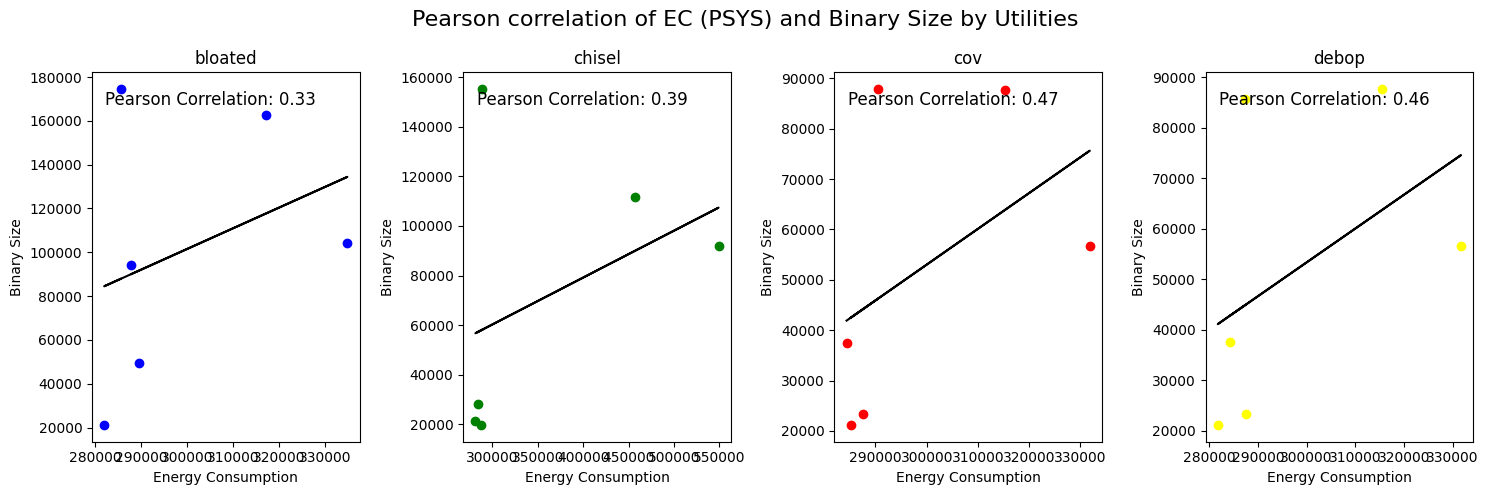

In [22]:
import pandas as pd
import numpy as np # It's needed for the "trend line"
import matplotlib.pyplot as plt

input_data = os.path.join(results_dir, 'all_ec_bsize.csv')
# First, we read the data from the CSV file with all experiments into a DataFrame
df = pd.read_csv(input_data, delimiter=";")
print(df)

# Convert 'PSYS' and 'Size' columns to numeric
df['PSYS'] = pd.to_numeric(df['PSYS'])
df['Size'] = pd.to_numeric(df['Size'])

# Create separate scatter plots for each utility with trend lines
utilities = ['bloated', 'chisel', 'cov', 'debop']
colors = ['blue', 'green', 'red', 'yellow']
fig, axes = plt.subplots(nrows=1, ncols=len(utilities), figsize=(15, 5))

for i, utility in enumerate(utilities):
    utility_df = df[df['Utilities'] == utility]
    axes[i].scatter(utility_df['PSYS'], utility_df['Size'], color=colors[i])
    axes[i].set_xlabel('Energy Consumption')
    axes[i].set_ylabel('Binary Size')
    axes[i].set_title(utility)

    # It calculate the Pearson correlation coefficient and shows it in the plot
    print()
    pearson_corr = utility_df[['PSYS', 'Size']].corr(method='pearson').iloc[0, 1]
    print(pearson_corr)
    axes[i].text(0.05, 0.95, f'Pearson Correlation: {pearson_corr:.2f}', 
                 transform=axes[i].transAxes, fontsize=12, verticalalignment='top')

    # Fit a linear regression line to the data points
    z = np.polyfit(utility_df['PSYS'], utility_df['Size'], 1)
    p = np.poly1d(z)
    axes[i].plot(utility_df['PSYS'], p(utility_df['PSYS']), color='black')

# We set the overall title for all three figures
fig.suptitle('Pearson correlation of EC (PSYS) and Binary Size by Utilities', fontsize=16)

# We adjust the spacing between subplots
plt.tight_layout()

# Finally, we show the plots
plt.show()


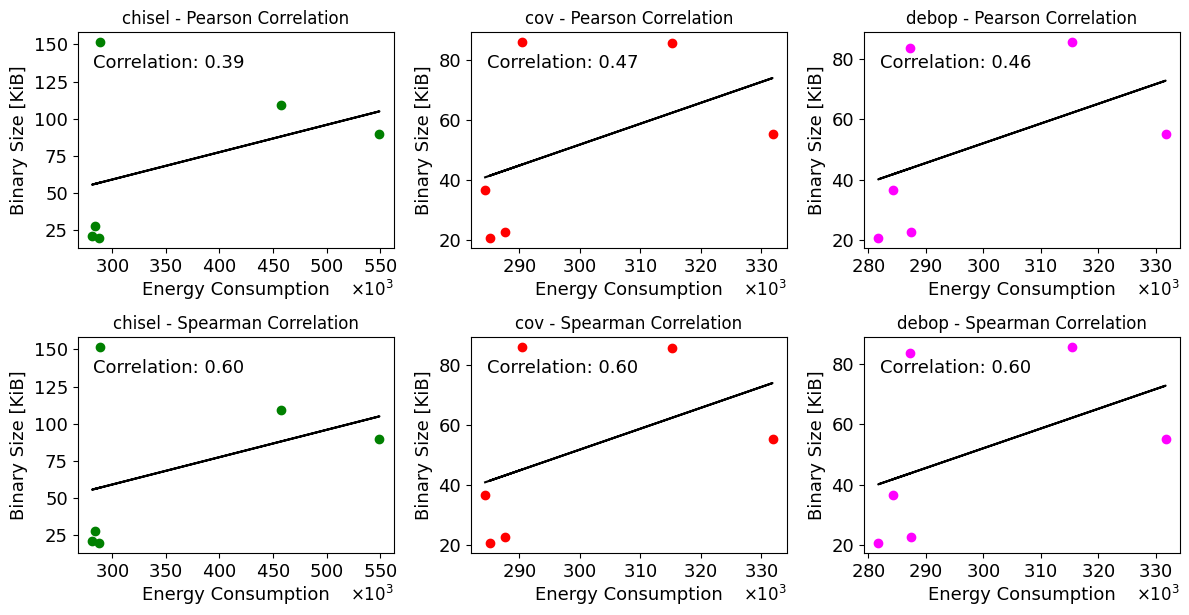

In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

input_data = os.path.join(results_dir, 'all_ec_bsize.csv')
df = pd.read_csv(input_data, delimiter=";")

df['PSYS'] = pd.to_numeric(df['PSYS'])
df['Size'] = pd.to_numeric(df['Size'])

# Convert Binary Size values from bytes to kibibytes (KiB)
df['Size_KiB'] = df['Size'] / 1024

utilities = ['bloated', 'chisel', 'cov', 'debop']
colors = ['blue', 'green', 'red', 'magenta']
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(12, 5))

for i, utility in enumerate(utilities):
    row = i // 4
    col = i % 4

    utility_df = df[df['Utilities'] == utility]

    # Scatter plot with Pearson correlation
    axes[row, col].scatter(utility_df['PSYS'], utility_df['Size_KiB'], color=colors[i])
    axes[row, col].set_xlabel('Energy Consumption')
    axes[row, col].set_ylabel('Binary Size [KiB]')  # Updated y-axis label
    axes[row, col].set_title(f'{utility} - Pearson Correlation')

    pearson_corr = utility_df[['PSYS', 'Size_KiB']].corr(method='pearson').iloc[0, 1]
    axes[row, col].text(0.05, 0.90, f'Correlation: {pearson_corr:.2f}', 
                        transform=axes[row, col].transAxes, fontsize=13, verticalalignment='top')  # Increased fontsize

    z = np.polyfit(utility_df['PSYS'], utility_df['Size_KiB'], 1)
    p = np.poly1d(z)
    axes[row, col].plot(utility_df['PSYS'], p(utility_df['PSYS']), color='black')

    # Scatter plot with Spearman correlation
    axes[row + 1, col].scatter(utility_df['PSYS'], utility_df['Size_KiB'], color=colors[i])
    axes[row + 1, col].set_xlabel('Energy Consumption')
    axes[row + 1, col].set_ylabel('Binary Size [KiB]')  # Updated y-axis label
    axes[row + 1, col].set_title(f'{utility} - Spearman Correlation')

    spearman_corr = utility_df[['PSYS', 'Size_KiB']].corr(method='spearman').iloc[0, 1]
    axes[row + 1, col].text(0.05, 0.90, f'Correlation: {spearman_corr:.2f}', 
                            transform=axes[row + 1, col].transAxes, fontsize=13, verticalalignment='top')  # Increased fontsize

    z = np.polyfit(utility_df['PSYS'], utility_df['Size_KiB'], 1)
    p = np.poly1d(z)
    axes[row + 1, col].plot(utility_df['PSYS'], p(utility_df['PSYS']), color='black')

# Adjust spacing between subplots
plt.tight_layout()

# Set the overall title for all charts
# fig.suptitle('Correlation of EC (PSYS) and Binary Size by Utilities', fontsize=16)

plt.show()


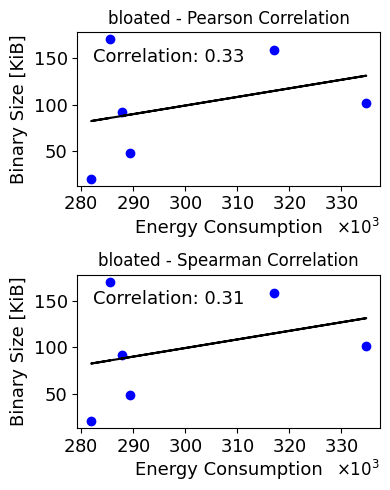

In [65]:
import pandas as pd
import numpy as np # It's needed for the "trend line"
import matplotlib.pyplot as plt

input_data = os.path.join(results_dir, 'all_ec_bsize.csv')
# First, we read the data from the CSV file with all experiments into a DataFrame
df = pd.read_csv(input_data, delimiter=";")

# Convert 'PSYS' and 'Size' columns to numeric
df['PSYS'] = pd.to_numeric(df['PSYS'])
df['Size'] = pd.to_numeric(df['Size'])

# Create separate scatter plots for each utility with trend lines
utilities = ['GNU', 'BusyBox', 'ToyBox']
colors = ['blue', 'green', 'red']
fig, axes = plt.subplots(nrows=1, ncols=len(utilities), figsize=(15, 5))

for i, utility in enumerate(utilities):
    utility_df = df[df['Utilities'] == utility]
    axes[i].scatter(utility_df['PSYS'], utility_df['Size'], color=colors[i])
    axes[i].set_xlabel('Energy Consumption')
    axes[i].set_ylabel('Binary Size')
    axes[i].set_title(utility)

    # It calculates the Spearman correlation coefficient and show it in the plot
    spearman_corr = utility_df[['PSYS', 'Size']].corr(method='spearman').iloc[0, 1]
    axes[i].text(0.05, 0.95, f'Spearman Correlation: {spearman_corr:.2f}', 
                 transform=axes[i].transAxes, fontsize=12, verticalalignment='top')

    # Fit a linear regression line to the data points
    z = np.polyfit(utility_df['PSYS'], utility_df['Size'], 1)
    p = np.poly1d(z)
    axes[i].plot(utility_df['PSYS'], p(utility_df['PSYS']), color='black')

# We set the overall title for all three figures
fig.suptitle('Spearman correlation of EC (PSYS) and Binary Size by Utilities', fontsize=16)

# We adjust the spacing between subplots
plt.tight_layout()

# Finally, we show the plots
plt.show()

TypeError: expected non-empty vector for x

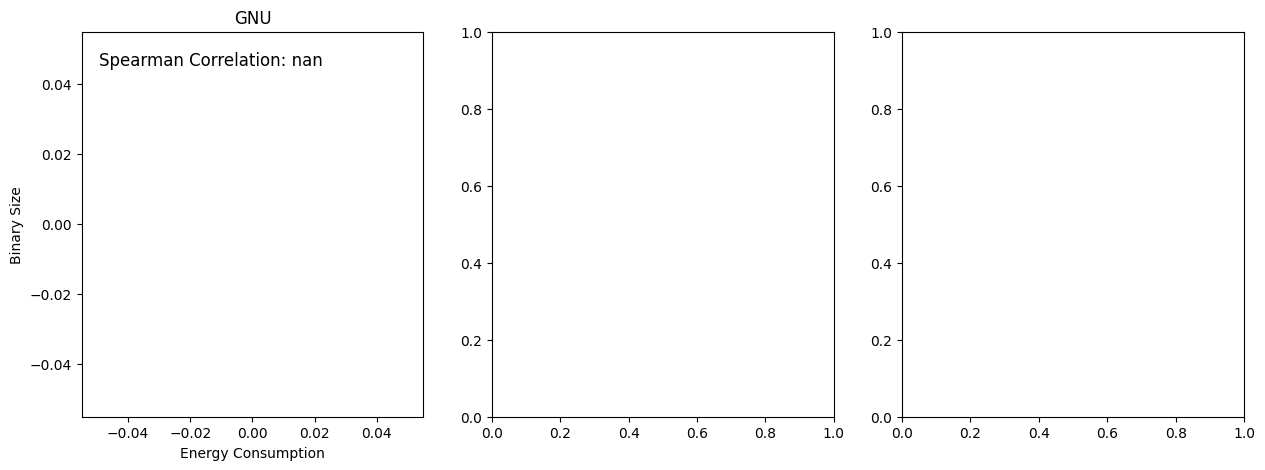

In [74]:
# Now we want to calculate the Peason correlation between the EC and Duration 
# for all utilities in each 3 different implementations

# The Spearman correlation with the p-value

import pandas as pd
from scipy.stats import spearmanr

input_data = os.path.join(results_dir, 'averageDURATION_all_repeats.csv')
# Read the CSV file into a DataFrame
df = pd.read_csv(input_data, delimiter=";")

# Convert 'PSYS' and 'Size' columns to numeric
df['PSYS'] = pd.to_numeric(df['PSYS'])
df['DURATION'] = pd.to_numeric(df['DURATION'])

# Calculate Spearman correlation and p-value for each 'Utilities' separately
results = df.groupby('Utilities').apply(lambda x: spearmanr(x['PSYS'], x['DURATION']))

# Extract the correlation coefficients and p-values
correlations = results.apply(lambda x: x.correlation)
p_values = results.apply(lambda x: x.pvalue)

# Combine correlations and p-values into a DataFrame
correlation_df = pd.DataFrame({'Spearman Correlation': correlations, 'p-value': p_values})

# Print the correlations and p-values
print(correlation_df)

In [75]:
# The Pearson correlation with the p-value

import pandas as pd
from scipy.stats import pearsonr

input_data = os.path.join(results_dir, 'averageDURATION_all_repeats.csv')
# Read the CSV file into a DataFrame
df = pd.read_csv(input_data, delimiter=";")

# Convert 'PSYS' and 'Size' columns to numeric
df['PSYS'] = pd.to_numeric(df['PSYS'])
df['DURATION'] = pd.to_numeric(df['DURATION'])

# Calculate Spearman correlation and p-value for each 'Utilities' separately
results = df.groupby('Utilities').apply(lambda x: pearsonr(x['PSYS'], x['DURATION']))

# Extract the correlation coefficients and p-values
correlations = results.apply(lambda x: x.correlation)
p_values = results.apply(lambda x: x.pvalue)

# Combine correlations and p-values into a DataFrame
correlation_df = pd.DataFrame({'Pearson Correlation': correlations, 'p-value': p_values})

# Print the correlations and p-values
print(correlation_df)

           Spearman Correlation   p-value
Utilities                                
bloated                1.000000  0.000000
chisel                 1.000000  0.000000
cov                    0.885714  0.018845
debop                  0.942857  0.004805


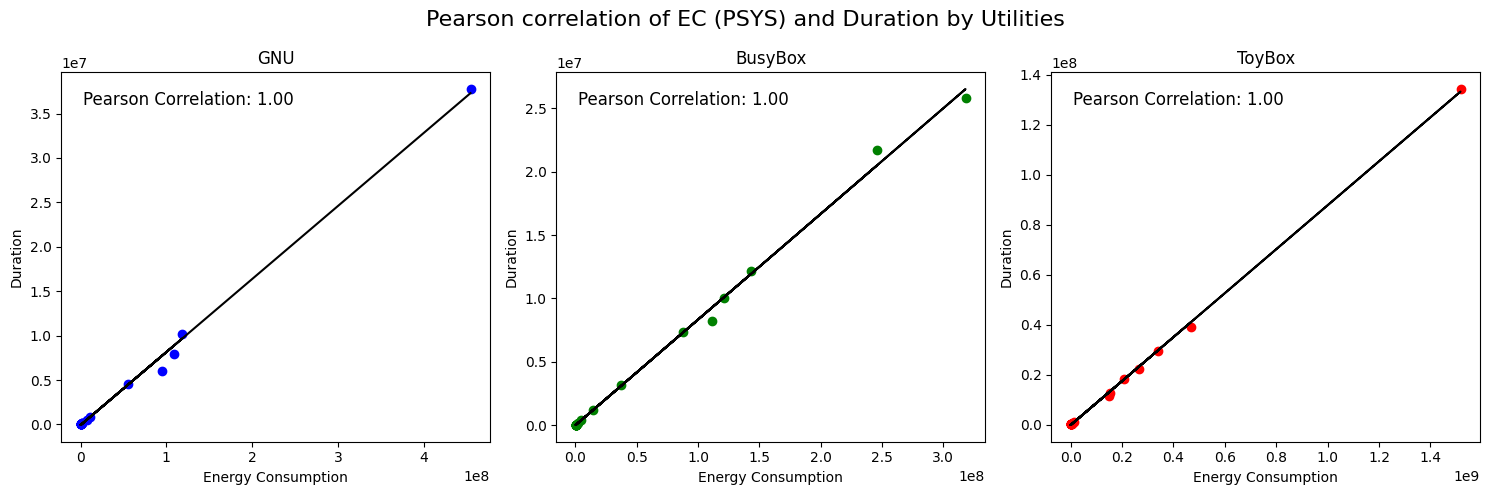

In [27]:
import pandas as pd
import numpy as np # It's needed for the "trend line"
import matplotlib.pyplot as plt

input_data = os.path.join(results_dir, 'averageDURATION_all_repeats.csv')
# First, we read the data from the CSV file with all experiments into a DataFrame
df = pd.read_csv(input_data, delimiter=";")

# Convert 'PSYS' and 'Size' columns to numeric
df['PSYS'] = pd.to_numeric(df['PSYS'])
df['DURATION'] = pd.to_numeric(df['DURATION'])

# Create separate scatter plots for each utility with trend lines
utilities = ['GNU', 'BusyBox', 'ToyBox']
colors = ['blue', 'green', 'red']
fig, axes = plt.subplots(nrows=1, ncols=len(utilities), figsize=(15, 5))

for i, utility in enumerate(utilities):
    utility_df = df[df['Utilities'] == utility]
    axes[i].scatter(utility_df['PSYS'], utility_df['DURATION'], color=colors[i])
    axes[i].set_xlabel('Energy Consumption')
    axes[i].set_ylabel('Duration')
    axes[i].set_title(utility)

    # It calculate the Pearson correlation coefficient and shows it in the plot
    pearson_corr = utility_df[['PSYS', 'DURATION']].corr(method='pearson').iloc[0, 1]
    axes[i].text(0.05, 0.95, f'Pearson Correlation: {pearson_corr:.2f}', 
                 transform=axes[i].transAxes, fontsize=12, verticalalignment='top')

    # Fit a linear regression line to the data points
    z = np.polyfit(utility_df['PSYS'], utility_df['DURATION'], 1)
    p = np.poly1d(z)
    axes[i].plot(utility_df['PSYS'], p(utility_df['PSYS']), color='black')

# We set the overall title for all three figures
fig.suptitle('Pearson correlation of EC (PSYS) and Duration by Utilities', fontsize=16)

# We adjust the spacing between subplots
plt.tight_layout()

# Finally, we show the plots
plt.show()

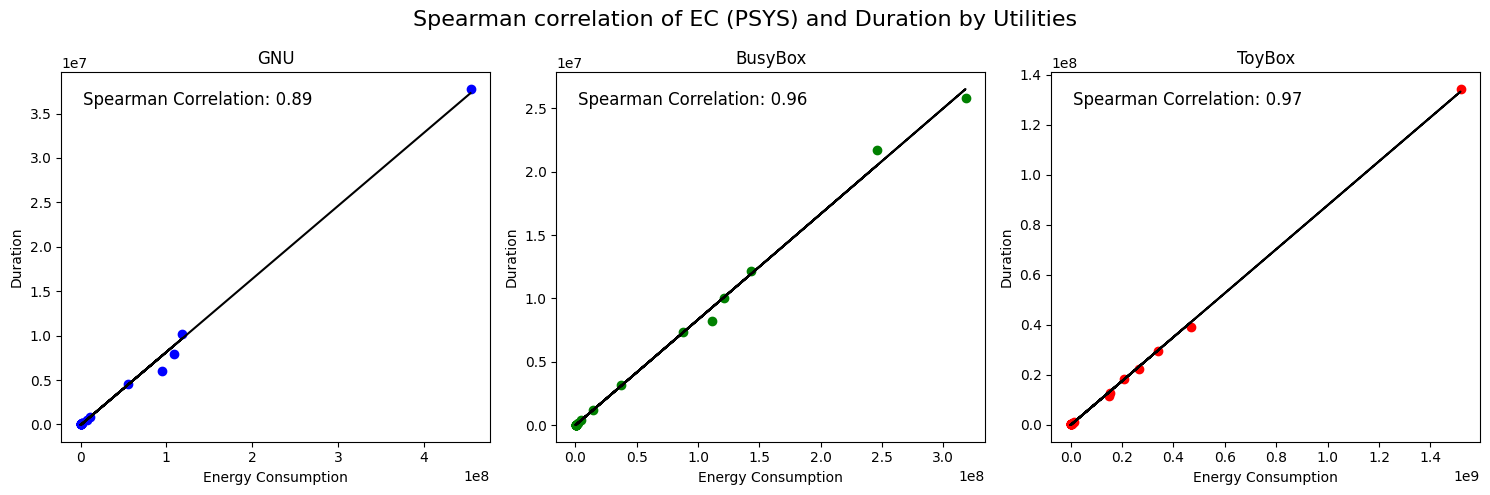

In [28]:
import pandas as pd
import numpy as np # It's needed for the "trend line"
import matplotlib.pyplot as plt

input_data = os.path.join(results_dir, 'averageDURATION_all_repeats.csv')
# First, we read the data from the CSV file with all experiments into a DataFrame
df = pd.read_csv(input_data, delimiter=";")

# Convert 'PSYS' and 'Size' columns to numeric
df['PSYS'] = pd.to_numeric(df['PSYS'])
df['DURATION'] = pd.to_numeric(df['DURATION'])

# Create separate scatter plots for each utility with trend lines
utilities = ['GNU', 'BusyBox', 'ToyBox']
colors = ['blue', 'green', 'red']
fig, axes = plt.subplots(nrows=1, ncols=len(utilities), figsize=(15, 5))

for i, utility in enumerate(utilities):
    utility_df = df[df['Utilities'] == utility]
    axes[i].scatter(utility_df['PSYS'], utility_df['DURATION'], color=colors[i])
    axes[i].set_xlabel('Energy Consumption')
    axes[i].set_ylabel('Duration')
    axes[i].set_title(utility)

    # It calculates the Spearman correlation coefficient and show it in the plot
    spearman_corr = utility_df[['PSYS', 'DURATION']].corr(method='spearman').iloc[0, 1]
    axes[i].text(0.05, 0.95, f'Spearman Correlation: {spearman_corr:.2f}', 
                 transform=axes[i].transAxes, fontsize=12, verticalalignment='top')

    # Fit a linear regression line to the data points
    z = np.polyfit(utility_df['PSYS'], utility_df['DURATION'], 1)
    p = np.poly1d(z)
    axes[i].plot(utility_df['PSYS'], p(utility_df['PSYS']), color='black')

# We set the overall title for all three figures
fig.suptitle('Spearman correlation of EC (PSYS) and Duration by Utilities', fontsize=16)

# We adjust the spacing between subplots
plt.tight_layout()

# Finally, we show the plots
plt.show()

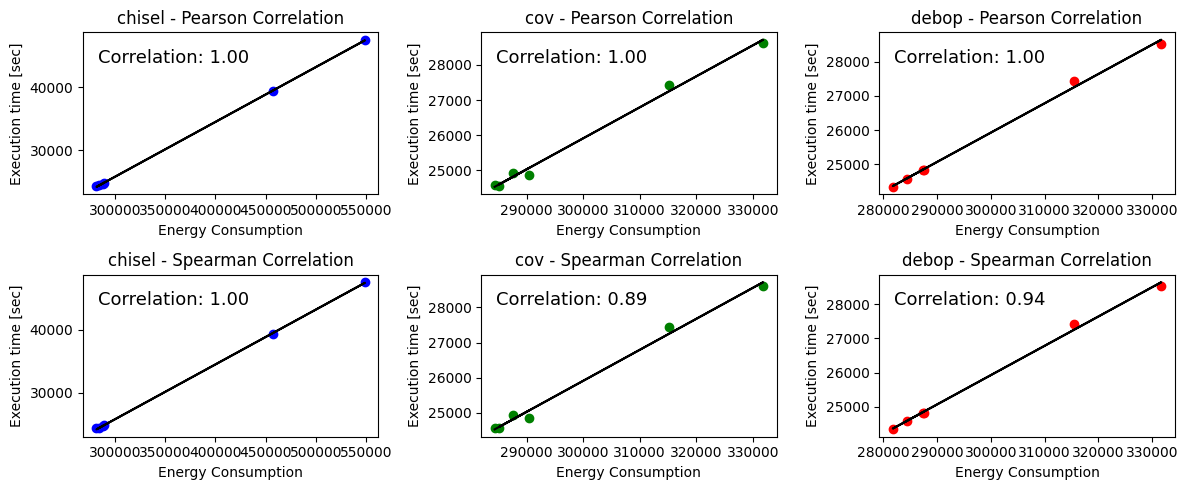

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

input_data = os.path.join(results_dir, 'averageDURATION_all_repeats.csv')
df = pd.read_csv(input_data, delimiter=";")

df['PSYS'] = pd.to_numeric(df['PSYS'])
df['DURATION'] = pd.to_numeric(df['DURATION'])

utilities = ['bloated', 'chisel', 'cov', 'debop']
colors = ['blue', 'green', 'red', 'magenta']
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(12, 5))

for i, utility in enumerate(utilities):
    row = i // 4
    col = i % 4

    utility_df = df[df['Utilities'] == utility]

    # Scatter plot with Pearson correlation
    axes[row, col].scatter(utility_df['PSYS'], utility_df['DURATION'], color=colors[i])
    axes[row, col].set_xlabel('Energy Consumption')
    axes[row, col].set_ylabel('Execution time [sec]')
    axes[row, col].set_title(f'{utility} - Pearson Correlation')

    pearson_corr = utility_df[['PSYS', 'DURATION']].corr(method='pearson').iloc[0, 1]
    axes[row, col].text(0.05, 0.90, f'Correlation: {pearson_corr:.2f}', 
                        transform=axes[row, col].transAxes, fontsize=13, verticalalignment='top')

    z = np.polyfit(utility_df['PSYS'], utility_df['DURATION'], 1)
    p = np.poly1d(z)
    axes[row, col].plot(utility_df['PSYS'], p(utility_df['PSYS']), color='black')

    # Scatter plot with Spearman correlation
    axes[row + 1, col].scatter(utility_df['PSYS'], utility_df['DURATION'], color=colors[i])
    axes[row + 1, col].set_xlabel('Energy Consumption')
    axes[row + 1, col].set_ylabel('Execution time [sec]')
    axes[row + 1, col].set_title(f'{utility} - Spearman Correlation')

    spearman_corr = utility_df[['PSYS', 'DURATION']].corr(method='spearman').iloc[0, 1]
    axes[row + 1, col].text(0.05, 0.90, f'Correlation: {spearman_corr:.2f}', 
                            transform=axes[row + 1, col].transAxes, fontsize=13, verticalalignment='top')

    z = np.polyfit(utility_df['PSYS'], utility_df['DURATION'], 1)
    p = np.poly1d(z)
    axes[row + 1, col].plot(utility_df['PSYS'], p(utility_df['PSYS']), color='black')

# Adjust spacing between subplots
plt.tight_layout()

# Set the overall title for all charts
# fig.suptitle('Correlation of EC (PSYS) and Binary Size by Utilities', fontsize=16)

plt.show()


/tmp/ipykernel_16989/2481001147.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[row, col].set_xticklabels(axes[row, col].get_xticks())
/tmp/ipykernel_16989/2481001147.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[row, col].set_xticklabels(axes[row, col].get_xticks())
/tmp/ipykernel_16989/2481001147.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[row, col].set_xticklabels(axes[row, col].get_xticks())


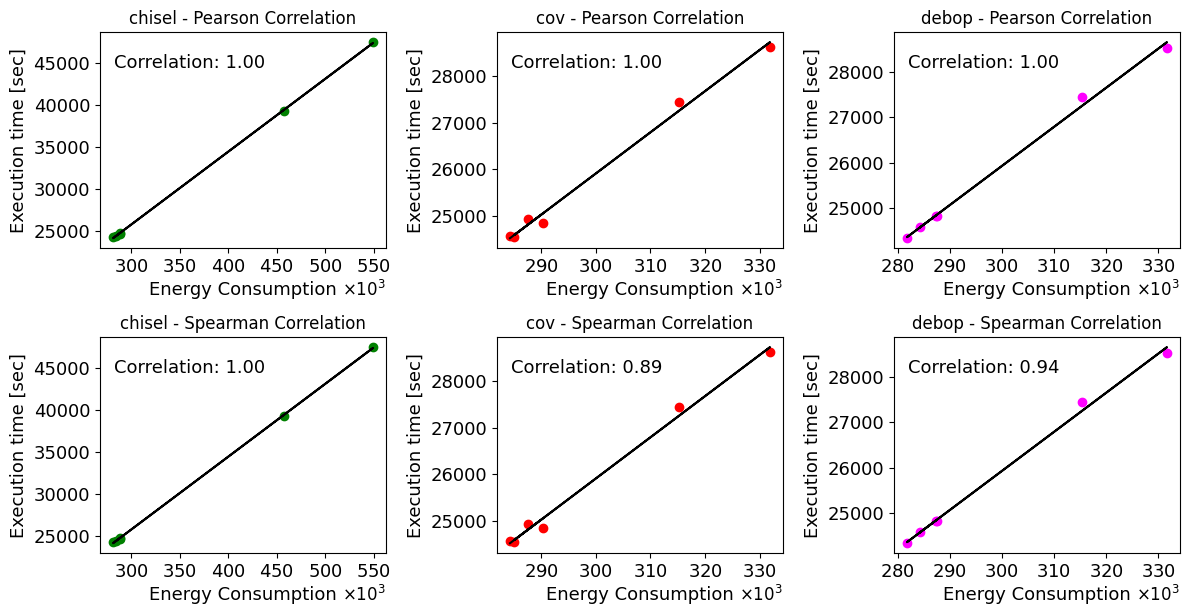

In [73]:
# Now we want to calculate the Peason correlation between the EC and Number of Configuration Options 
# for all utilities in each 3 different implementations

# The Spearman correlation with the p-value

import pandas as pd
from scipy.stats import spearmanr

input_data = os.path.join(results_dir, 'all_ec_options.csv')
# Read the CSV file into a DataFrame
df = pd.read_csv(input_data, delimiter=";")

# Convert 'PSYS' and 'Size' columns to numeric
df['PSYS'] = pd.to_numeric(df['PSYS'])
df['Options'] = pd.to_numeric(df['Options'])

# Calculate Spearman correlation and p-value for each 'Utilities' separately
results = df.groupby('Utilities').apply(lambda x: spearmanr(x['PSYS'], x['Options']))

# Extract the correlation coefficients and p-values
correlations = results.apply(lambda x: x.correlation)
p_values = results.apply(lambda x: x.pvalue)

# Combine correlations and p-values into a DataFrame
correlation_df = pd.DataFrame({'Spearman Correlation': correlations, 'p-value': p_values})

# Print the correlations and p-values
print(correlation_df)

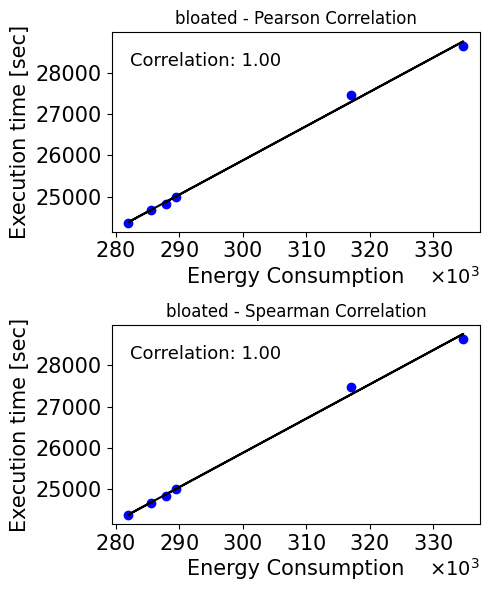

In [68]:
# The Pearson correlation with the p-value

import pandas as pd
from scipy.stats import pearsonr

input_data = os.path.join(results_dir, 'all_ec_options.csv')
# Read the CSV file into a DataFrame
df = pd.read_csv(input_data, delimiter=";")

# Convert 'PSYS' and 'Size' columns to numeric
df['PSYS'] = pd.to_numeric(df['PSYS'])
df['Options'] = pd.to_numeric(df['Options'])

# Calculate Spearman correlation and p-value for each 'Utilities' separately
results = df.groupby('Utilities').apply(lambda x: pearsonr(x['PSYS'], x['Options']))

# Extract the correlation coefficients and p-values
correlations = results.apply(lambda x: x.correlation)
p_values = results.apply(lambda x: x.pvalue)

# Combine correlations and p-values into a DataFrame
correlation_df = pd.DataFrame({'Pearson Correlation': correlations, 'p-value': p_values})

# Print the correlations and p-values
print(correlation_df)

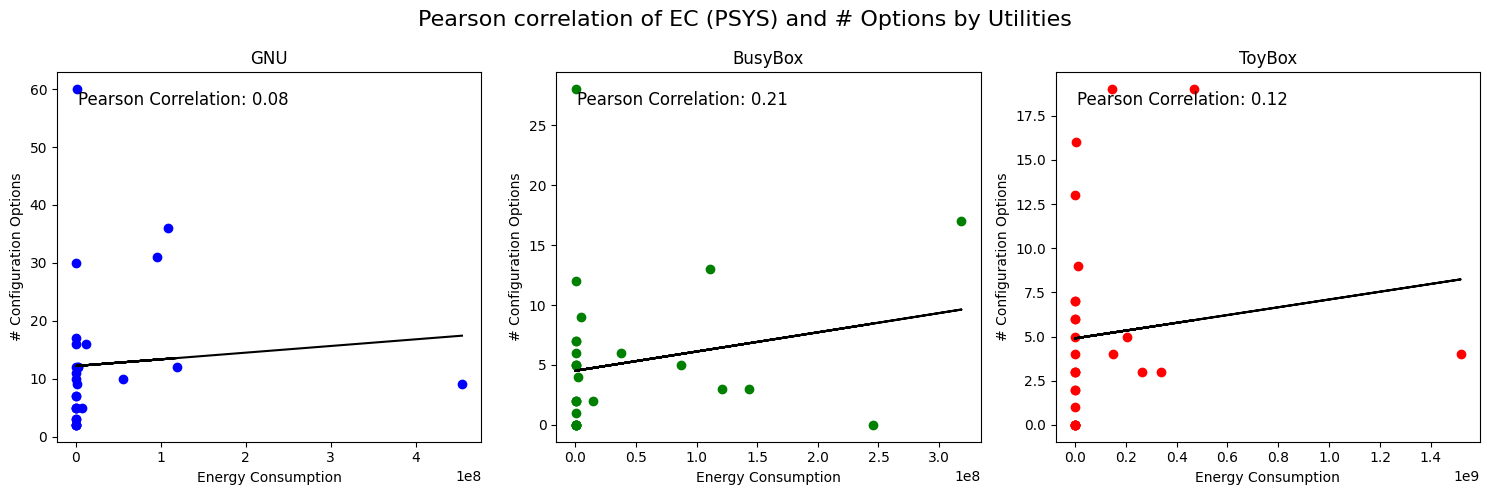

In [31]:
import pandas as pd
import numpy as np # It's needed for the "trend line"
import matplotlib.pyplot as plt

input_data = os.path.join(results_dir, 'all_ec_options.csv')
# First, we read the data from the CSV file with all experiments into a DataFrame
df = pd.read_csv(input_data, delimiter=";")

# Convert 'PSYS' and 'Size' columns to numeric
df['PSYS'] = pd.to_numeric(df['PSYS'])
df['Options'] = pd.to_numeric(df['Options'])

# Create separate scatter plots for each utility with trend lines
utilities = ['GNU', 'BusyBox', 'ToyBox']
colors = ['blue', 'green', 'red']
fig, axes = plt.subplots(nrows=1, ncols=len(utilities), figsize=(15, 5))

for i, utility in enumerate(utilities):
    utility_df = df[df['Utilities'] == utility]
    axes[i].scatter(utility_df['PSYS'], utility_df['Options'], color=colors[i])
    axes[i].set_xlabel('Energy Consumption')
    axes[i].set_ylabel('# Configuration Options')
    axes[i].set_title(utility)

    # It calculate the Pearson correlation coefficient and shows it in the plot
    pearson_corr = utility_df[['PSYS', 'Options']].corr(method='pearson').iloc[0, 1]
    axes[i].text(0.05, 0.95, f'Pearson Correlation: {pearson_corr:.2f}', 
                 transform=axes[i].transAxes, fontsize=12, verticalalignment='top')

    # Fit a linear regression line to the data points
    z = np.polyfit(utility_df['PSYS'], utility_df['Options'], 1)
    p = np.poly1d(z)
    axes[i].plot(utility_df['PSYS'], p(utility_df['PSYS']), color='black')

# We set the overall title for all three figures
fig.suptitle('Pearson correlation of EC (PSYS) and # Options by Utilities', fontsize=16)

# We adjust the spacing between subplots
plt.tight_layout()

# Finally, we show the plots
plt.show()

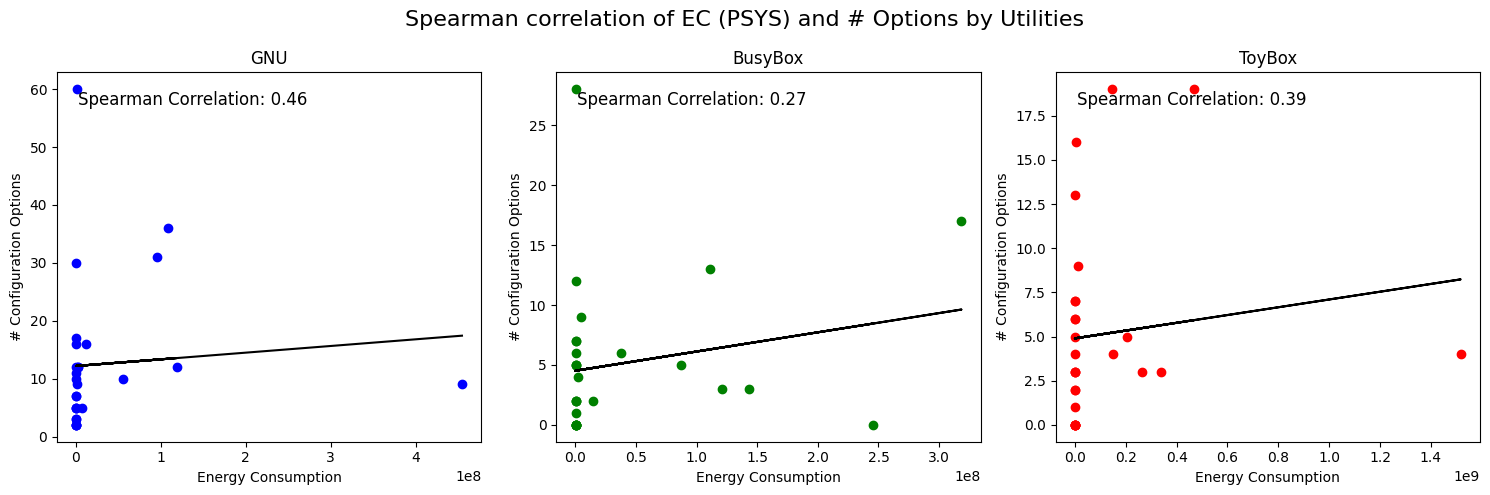

In [32]:
import pandas as pd
import numpy as np # It's needed for the "trend line"
import matplotlib.pyplot as plt

input_data = os.path.join(results_dir, 'all_ec_options.csv')
# First, we read the data from the CSV file with all experiments into a DataFrame
df = pd.read_csv(input_data, delimiter=";")

# Convert 'PSYS' and 'Size' columns to numeric
df['PSYS'] = pd.to_numeric(df['PSYS'])
df['Options'] = pd.to_numeric(df['Options'])

# Create separate scatter plots for each utility with trend lines
utilities = ['GNU', 'BusyBox', 'ToyBox']
colors = ['blue', 'green', 'red']
fig, axes = plt.subplots(nrows=1, ncols=len(utilities), figsize=(15, 5))

for i, utility in enumerate(utilities):
    utility_df = df[df['Utilities'] == utility]
    axes[i].scatter(utility_df['PSYS'], utility_df['Options'], color=colors[i])
    axes[i].set_xlabel('Energy Consumption')
    axes[i].set_ylabel('# Configuration Options')
    axes[i].set_title(utility)

    # It calculates the Spearman correlation coefficient and show it in the plot
    spearman_corr = utility_df[['PSYS', 'Options']].corr(method='spearman').iloc[0, 1]
    axes[i].text(0.05, 0.95, f'Spearman Correlation: {spearman_corr:.2f}', 
                 transform=axes[i].transAxes, fontsize=12, verticalalignment='top')

    # Fit a linear regression line to the data points
    z = np.polyfit(utility_df['PSYS'], utility_df['Options'], 1)
    p = np.poly1d(z)
    axes[i].plot(utility_df['PSYS'], p(utility_df['PSYS']), color='black')

# We set the overall title for all three figures
fig.suptitle('Spearman correlation of EC (PSYS) and # Options by Utilities', fontsize=16)

# We adjust the spacing between subplots
plt.tight_layout()

# Finally, we show the plots
plt.show()

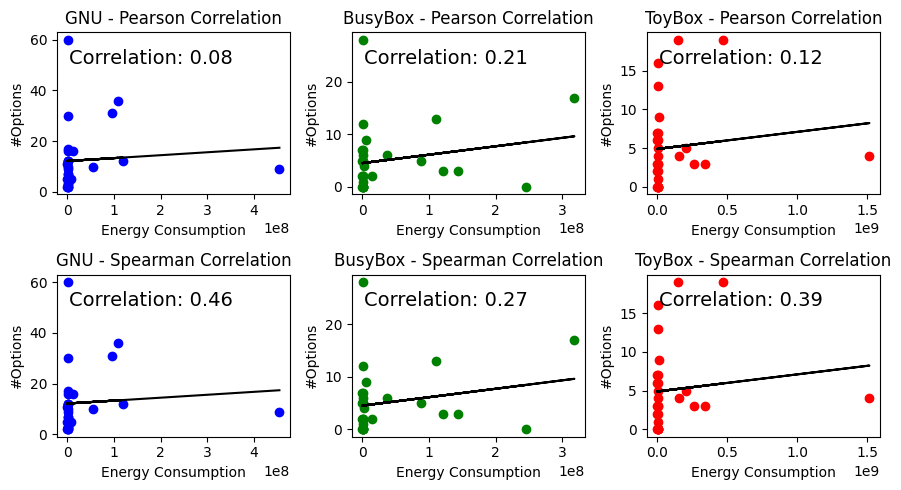

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

input_data = os.path.join(results_dir, 'all_ec_options.csv')
df = pd.read_csv(input_data, delimiter=";")

df['PSYS'] = pd.to_numeric(df['PSYS'])
df['Options'] = pd.to_numeric(df['Options'])

utilities = ['GNU', 'BusyBox', 'ToyBox']
colors = ['blue', 'green', 'red']
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(9, 5))

for i, utility in enumerate(utilities):
    row = i // 3
    col = i % 3

    utility_df = df[df['Utilities'] == utility]

    # Scatter plot with Pearson correlation
    axes[row, col].scatter(utility_df['PSYS'], utility_df['Options'], color=colors[i])
    axes[row, col].set_xlabel('Energy Consumption')
    axes[row, col].set_ylabel('#Options')  # Updated y-axis label
    axes[row, col].set_title(f'{utility} - Pearson Correlation')

    pearson_corr = utility_df[['PSYS', 'Options']].corr(method='pearson').iloc[0, 1]
    axes[row, col].text(0.05, 0.90, f'Correlation: {pearson_corr:.2f}', 
                        transform=axes[row, col].transAxes, fontsize=14, verticalalignment='top')  # Increased fontsize

    z = np.polyfit(utility_df['PSYS'], utility_df['Options'], 1)
    p = np.poly1d(z)
    axes[row, col].plot(utility_df['PSYS'], p(utility_df['PSYS']), color='black')

    # Scatter plot with Spearman correlation
    axes[row + 1, col].scatter(utility_df['PSYS'], utility_df['Options'], color=colors[i])
    axes[row + 1, col].set_xlabel('Energy Consumption')
    axes[row + 1, col].set_ylabel('#Options')  # Updated y-axis label
    axes[row + 1, col].set_title(f'{utility} - Spearman Correlation')

    spearman_corr = utility_df[['PSYS', 'Options']].corr(method='spearman').iloc[0, 1]
    axes[row + 1, col].text(0.05, 0.90, f'Correlation: {spearman_corr:.2f}', 
                            transform=axes[row + 1, col].transAxes, fontsize=14, verticalalignment='top')  # Increased fontsize

    z = np.polyfit(utility_df['PSYS'], utility_df['Options'], 1)
    p = np.poly1d(z)
    axes[row + 1, col].plot(utility_df['PSYS'], p(utility_df['PSYS']), color='black')

# Adjust spacing between subplots
plt.tight_layout()

# Set the overall title for all charts
# fig.suptitle('Correlation of EC (PSYS) and Binary Size by Utilities', fontsize=16)

plt.show()
